In [2]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
from optimizers.ladagrad import LAdagrad
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from training.train import train, plot_langevin_loss
from diffusion.oil_drilling import OilDrilling
from scheduler import PiecewiseConstantScheduler
import os

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


We consider the control problem in the management of natural resources applied to oil drilling introduced in [GKL18] and extended in [GGKL21]. The objective is for an oil driller, to balance the costs of extraction, storage in a volatile energy market. The oil price $P_{t} \in\mathbb{R}$ is assumed to be a Black-Scholes process:
$$
d P_{t}=\mu P_{t} d t+\eta P_{t} d W_{t}. \tag{5.1} 
$$
The control is given by $q_{t}=( q_{t}^{v}, q_{t}^{s}, q_{t}^{v, s} ) \in\mathbb{R}^{3}$ where $q_{t}^{v}$ is the quantity of extracted oil immediately sold on the market per time unit, $q_{t}^{s}$ is the quantity of extracted oil that is stored per time unit, and $q_{t}^{v, s}$ is the quantity of stored oil that is sold per time unit. The cumulated quantities of extracted and stored oil at time $t$ are respectively given by
$$
E_{t}=\int_{0}^{t} ( q_{r}^{v}+q_{r}^{s} ) d r, \quad S_{t}=\int_{0}^{t} ( q_{r}^{s}-q_{r}^{v, s} ) d r. \tag{5.2} 
$$
The extraction and storage prices are respectively given by
$$
c_{e} ( E_{t} )=\operatorname{e x p} \left( \xi_{e} E_{t} \right), \quad c_{s} ( S_{t} )=\operatorname{e x p} \left( \xi_{s} S_{t} \right)-1. \tag{5.3} 
$$
The constraints on the control are the following:
$$
q_{t}^{v}, \ q_{t}^{s}, \ q_{t}^{v, s} \geq0, \quad q_{t}^{v, s} \leq q^{S}, \quad q_{t}^{v}+q_{t}^{s} \leq K_{0}, \quad0 \leq S_{t} \leq Q^{S}, \tag{5.4} 
$$
where $q^{S}$, $K_{0}$ and $Q^{S}$ are operational bounds. The objective is
$$
J ( q )=-\mathbb{E} \left[ \int_{0}^{T} e^{-\rho r} U \Big( q_{r}^{v} P_{r}+q_{r}^{v, s} ( 1-\varepsilon) P_{r}-( q_{r}^{v}+q_{r}^{s} ) c_{e} ( E_{r} )-c_{s} ( S_{r} ) \Big) d r \right], \tag{5.5} 
$$
where $U : \mathbb{R} \to\mathbb{R}$ is the utility function.
In the experiments we take
$$
\begin{array} {l} {{{T=1, \ \mu=0. 0 1, \ \eta=0. 2, \ \rho=0. 0 1, \ \varepsilon=0, \ K_{0}=5,}}} \\ {{{\xi_{e}=1 \, \mathrm{e}-2, \ \xi_{s}=5 \, \mathrm{e}-3, \ q^{S}=1 0, \ P_{0}=1, \ U ( x )=x.}}} \\ \end{array} \tag{5.6} 
$$

In [3]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25

### Single control:

In [4]:
def test_diag_single_ctrl(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = OilDrilling(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        vanilla_optim = optim(ocp.control.parameters(), lr=lr, **optim_kwargs)
        scheduler = PiecewiseConstantScheduler(
            vanilla_optim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            vanilla_optim,
            scheduler,
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)), test_loss, marker="o", mec="k", ms=3, label=name
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = OilDrilling(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        loptim = langevin_optim(ocp.control.parameters(), lr=lr, sigma=sigma[i])
        scheduler = PiecewiseConstantScheduler(
            loptim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            loptim,
            scheduler,
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

    plt.show()
    plt.close()

    return fig

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim),
    U=(lambda x: x),
    device=device,
)

control_config = dict(
    input_dim=1 + 3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=0.000, train=-0.201, test=-0.200: 100%|██████████| 80/80 [00:15<00:00,  5.03it/s]
Oil Drilling: Epoch 79, L-Adam, lr=0.000, sigma=0.000, train=-0.186, test=-0.177: 100%|██████████| 80/80 [00:15<00:00,  5.13it/s]
Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=0.000, train=-0.178, test=-0.178: 100%|██████████| 80/80 [00:25<00:00,  3.08it/s]
Oil Drilling: Epoch 79, L-Adam, lr=0.000, sigma=0.000, train=-0.208, test=-0.209: 100%|██████████| 80/80 [00:25<00:00,  3.12it/s]
Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=0.000, train=-0.208, test=-0.210: 100%|██████████| 80/80 [00:52<00:00,  1.52it/s]
Oil Drilling: Epoch 79, L-Adam, lr=0.000, sigma=0.000, train=-0.206, test=-0.203: 100%|██████████| 80/80 [00:50<00:00,  1.57it/s]


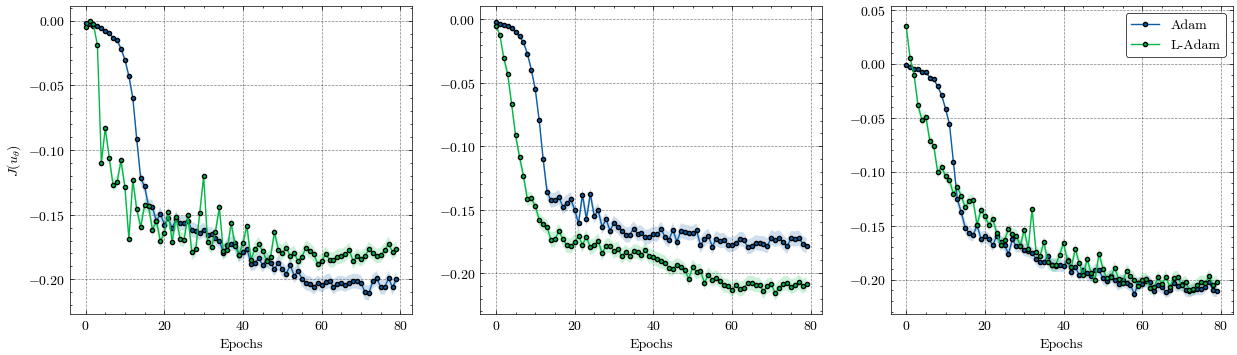

In [6]:
adam_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [1e-3, 1e-3, 1e-3],
    80,
    60,
)

Oil Drilling: Epoch 79, Adagrad, lr=0.001, sigma=0.000, train=-0.147, test=-0.139: 100%|██████████| 80/80 [00:15<00:00,  5.23it/s]
Oil Drilling: Epoch 79, L-Adagrad, lr=0.001, sigma=0.000, train=-0.159, test=-0.171: 100%|██████████| 80/80 [00:15<00:00,  5.14it/s]
Oil Drilling: Epoch 79, Adagrad, lr=0.001, sigma=0.000, train=-0.153, test=-0.150: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]
Oil Drilling: Epoch 79, L-Adagrad, lr=0.001, sigma=0.000, train=-0.148, test=-0.167: 100%|██████████| 80/80 [00:25<00:00,  3.12it/s]
Oil Drilling: Epoch 79, Adagrad, lr=0.001, sigma=0.000, train=-0.142, test=-0.150: 100%|██████████| 80/80 [00:53<00:00,  1.51it/s]
Oil Drilling: Epoch 79, L-Adagrad, lr=0.001, sigma=0.000, train=-0.170, test=-0.168: 100%|██████████| 80/80 [00:52<00:00,  1.52it/s]


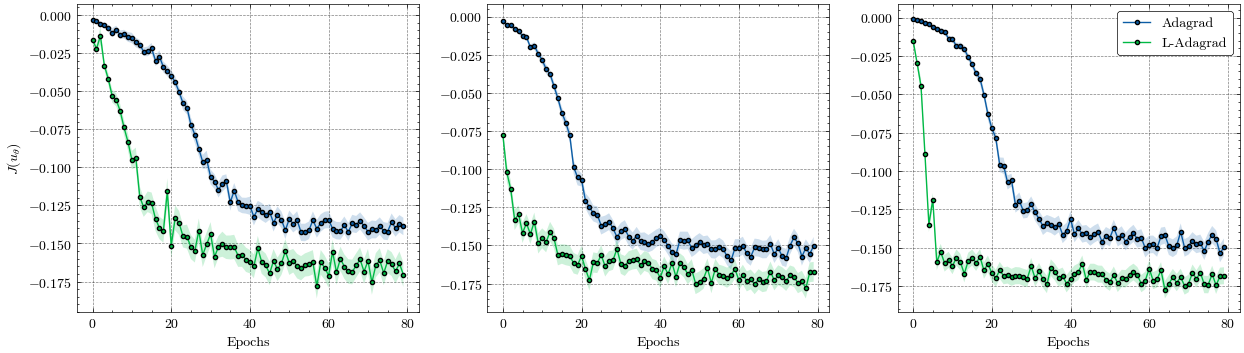

In [7]:
adagrad_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adagrad,
    LAdagrad,
    "Adagrad",
    5e-3,
    5e-4,
    [5e-5, 5e-5, 5e-5],
    80,
    60,
)

Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=-0.207, test=-0.202: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]
Oil Drilling: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=-0.222, test=-0.219: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]
Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=-0.198, test=-0.196: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]
Oil Drilling: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=-0.221, test=-0.218: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]
Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=-0.212, test=-0.215: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]
Oil Drilling: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=-0.233, test=-0.225: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


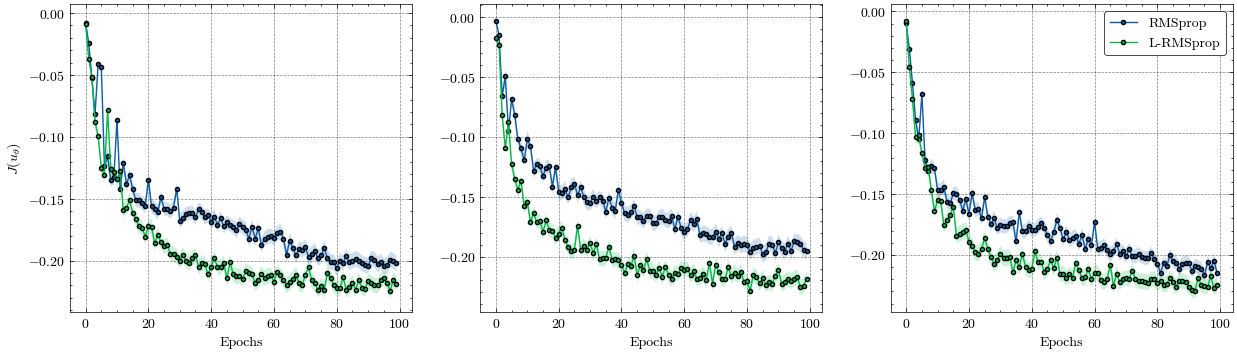

In [8]:
rmsprop_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [2e-3, 2e-3, 2e-3],
    100,
    80,
)

Oil Drilling: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=-0.209, test=-0.210: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]
Oil Drilling: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=-0.211, test=-0.213: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]
Oil Drilling: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=-0.208, test=-0.206: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]
Oil Drilling: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=-0.227, test=-0.221: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]
Oil Drilling: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=-0.202, test=-0.205: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]
Oil Drilling: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=-0.230, test=-0.226: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


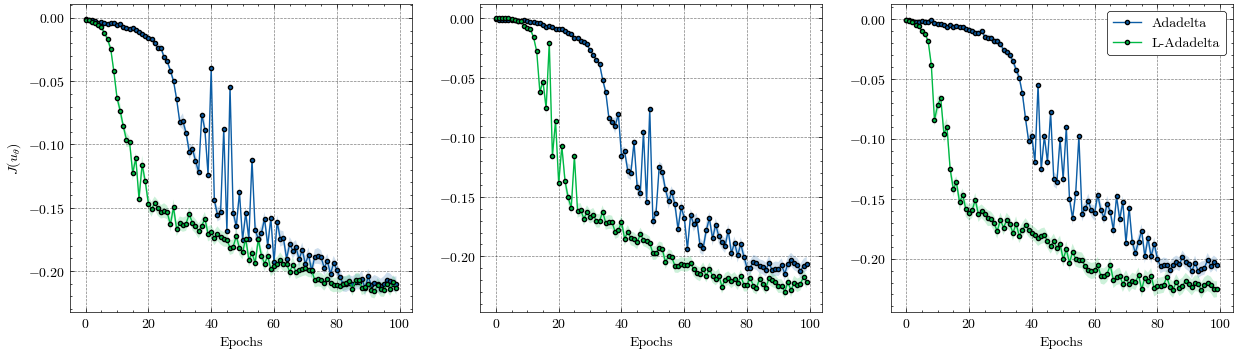

In [9]:
adadelta_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [5e-3, 5e-3, 5e-3],
    100,
    80,
    rho=0.95,
)

Oil Drilling: Epoch 99, SGD, lr=0.005, sigma=0.000, train=-0.203, test=-0.218: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]
Oil Drilling: Epoch 99, L-SGD, lr=0.005, sigma=0.000, train=0.000, test=0.000: 100%|██████████| 100/100 [00:31<00:00,  3.15it/s] 
Oil Drilling: Epoch 99, SGD, lr=0.005, sigma=0.000, train=-0.231, test=-0.216: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]
Oil Drilling: Epoch 99, L-SGD, lr=0.005, sigma=0.000, train=-0.225, test=-0.225: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]
Oil Drilling: Epoch 99, SGD, lr=0.005, sigma=0.000, train=-0.216, test=-0.220: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]
Oil Drilling: Epoch 99, L-SGD, lr=0.005, sigma=0.000, train=-0.235, test=-0.234: 100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


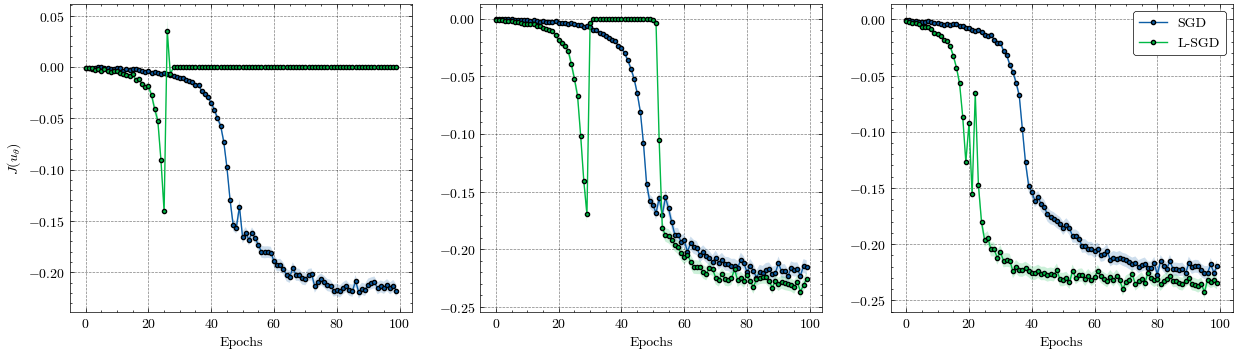

In [10]:
sgd_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.SGD,
    APLSGD,
    "SGD",
    5e-2,
    5e-3,
    [1e-3, 1e-3, 1e-3],
    100,
    80,
    momentum=0.9,
)

In [11]:
if os.path.isdir("graphs/oil_drilling"):
    adam_single_ctrl.savefig("graphs/oil_drilling/adam_single_ctrl.pdf")
    adadelta_single_ctrl.savefig("graphs/oil_drilling/adadelta_single_ctrl.pdf")
    rmsprop_single_ctrl.savefig("graphs/oil_drilling/rmsprop_single_ctrl.pdf")
    sgd_single_ctrl.savefig("graphs/oil_drilling/sgd_single_ctrl.pdf")
    adagrad_single_ctrl.savefig("graphs/oil_drilling/adagrad_single_ctrl.pdf")

### Multiple controls:

In [12]:
def test_diag_multiple_ctrls(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    ll,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = OilDrilling(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=True)
        vanilla_optim = [
            optim(control.parameters(), lr=lr, **optim_kwargs)
            for control in ocp.control
        ]
        scheduler = [
            PiecewiseConstantScheduler(
                optimizer, target_lr=target_lr, target_sigma=0, total_iters=total_iters
            )
            for optimizer in vanilla_optim
        ]
        train_loss, test_loss, test_ci = train(
            ocp,
            vanilla_optim,
            scheduler,
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)), test_loss, marker="o", mec="k", ms=3, label=name
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = OilDrilling(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=True)
        loptim = [
            langevin_optim(control.parameters(), lr=lr, sigma=sigma[i])
            for control in ocp.control
        ]
        scheduler = [
            PiecewiseConstantScheduler(
                optimizer, target_lr=target_lr, target_sigma=0, total_iters=total_iters
            )
            for optimizer in loptim
        ]
        train_loss, test_loss, test_ci = train(
            ocp,
            loptim,
            scheduler,
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Layer Langevin algo
        for ll_rate in ll:
            ocp = OilDrilling(**model_config, N_euler=N)
            ocp.set_control(control_config, multiple_controls=True)
            lloptim = []
            scheduler = []
            for j, control in enumerate(ocp.control):
                if 100 * j / len(ocp.control) <= ll_rate:
                    lloptim.append(
                        langevin_optim(control.parameters(), lr=lr, sigma=sigma[i])
                    )
                else:
                    lloptim.append(optim(control.parameters(), lr=lr, **optim_kwargs))
                scheduler.append(
                    PiecewiseConstantScheduler(
                        lloptim[j],
                        target_lr=target_lr,
                        target_sigma=0,
                        total_iters=total_iters,
                    )
                )
            train_loss, test_loss, test_ci = train(
                ocp,
                lloptim,
                scheduler,
                f"LL-{name} {ll_rate}%",
                epochs,
                train_size,
                test_size,
                train_batch,
                test_batch,
            )
            axs[i].plot(
                np.arange(len(test_loss)),
                test_loss,
                marker="o",
                mec="k",
                ms=3,
                label=f"LL-{name} {ll_rate}%",
            )
            axs[i].fill_between(
                np.arange(len(test_loss)),
                np.array(test_loss) - np.array(test_ci),
                np.array(test_loss) + np.array(test_ci),
                alpha=0.2,
            )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

    plt.show()
    plt.close()

    return fig

In [13]:
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim).to(device),
    U=(lambda x: x),
    device=device,
)

control_config = dict(
    input_dim=3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

Oil Drilling: Epoch 49, Adam, lr=0.000, sigma=0.000, train=-0.162, test=-0.170: 100%|██████████| 50/50 [00:06<00:00,  7.30it/s]
Oil Drilling: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=-0.185, test=-0.196: 100%|██████████| 50/50 [00:07<00:00,  6.46it/s]
Oil Drilling: Epoch 49, LL-Adam 30%, lr=0.000, sigma=0.000, train=-0.172, test=-0.186: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s]
Oil Drilling: Epoch 49, LL-Adam 90%, lr=0.000, sigma=0.000, train=-0.181, test=-0.185: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Oil Drilling: Epoch 49, Adam, lr=0.000, sigma=0.000, train=-0.174, test=-0.177: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]
Oil Drilling: Epoch 49, L-Adam, lr=0.000, sigma=0.000, train=-0.209, test=-0.206: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s]
Oil Drilling: Epoch 49, LL-Adam 30%, lr=0.000, sigma=0.000, train=-0.174, test=-0.183: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]
Oil Drilling: Epoch 49, LL-Adam 90%, lr=0.000, sigma=0.000, train=-0.206, test=

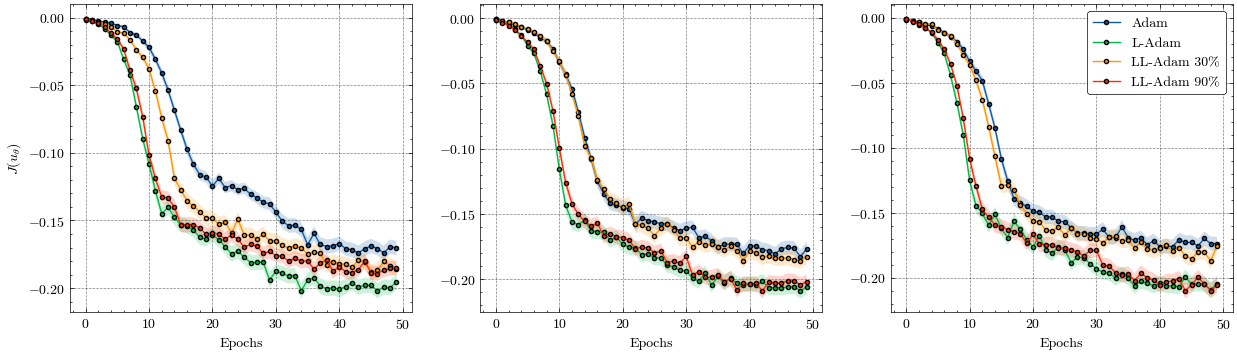

In [14]:
adam_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [2e-4, 2e-4, 2e-4],
    [30, 90],
    50,
    40,
)

Oil Drilling: Epoch 49, Adagrad, lr=0.001, sigma=0.000, train=-0.095, test=-0.106: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]
Oil Drilling: Epoch 49, L-Adagrad, lr=0.001, sigma=0.000, train=-0.164, test=-0.180: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]
Oil Drilling: Epoch 49, LL-Adagrad 30%, lr=0.001, sigma=0.000, train=-0.139, test=-0.153: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]
Oil Drilling: Epoch 49, LL-Adagrad 90%, lr=0.001, sigma=0.000, train=-0.145, test=-0.164: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]
Oil Drilling: Epoch 49, Adagrad, lr=0.001, sigma=0.000, train=-0.116, test=-0.131: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]
Oil Drilling: Epoch 49, L-Adagrad, lr=0.001, sigma=0.000, train=-0.185, test=-0.187: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s]
Oil Drilling: Epoch 49, LL-Adagrad 30%, lr=0.001, sigma=0.000, train=-0.134, test=-0.153: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]
Oil Drilling: Epoch 49, LL-Adagrad 90%, lr=0.001, sigma=0.

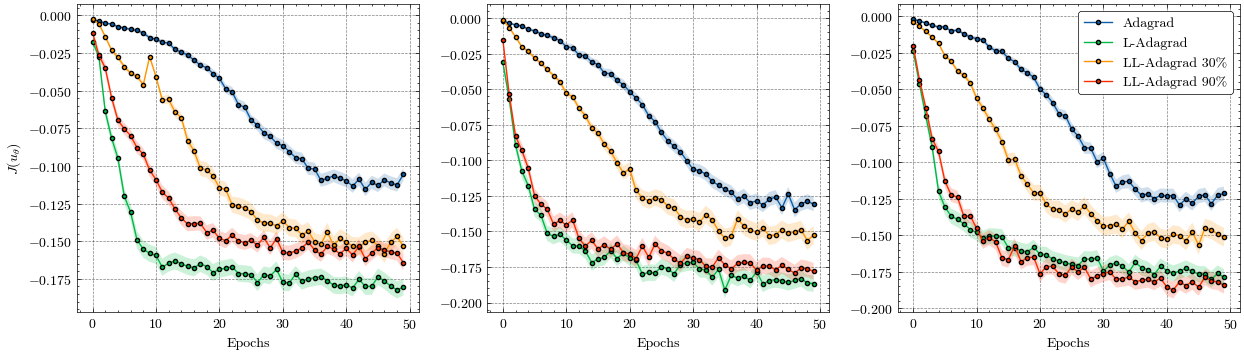

In [15]:
adagrad_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adagrad,
    LAdagrad,
    "Adagrad",
    5e-3,
    5e-4,
    [5e-5, 5e-5, 5e-5],
    [30, 90],
    50,
    40,
)

Oil Drilling: Epoch 49, Adadelta, lr=0.050, sigma=0.000, train=-0.002, test=-0.001: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]
Oil Drilling: Epoch 49, L-Adadelta, lr=0.050, sigma=0.000, train=-0.132, test=-0.139: 100%|██████████| 50/50 [00:09<00:00,  5.55it/s]
Oil Drilling: Epoch 49, LL-Adadelta 30%, lr=0.050, sigma=0.000, train=-0.004, test=-0.006: 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]
Oil Drilling: Epoch 49, LL-Adadelta 90%, lr=0.050, sigma=0.000, train=-0.143, test=-0.153: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
Oil Drilling: Epoch 49, Adadelta, lr=0.050, sigma=0.000, train=-0.001, test=-0.001: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]
Oil Drilling: Epoch 49, L-Adadelta, lr=0.050, sigma=0.000, train=-0.101, test=-0.104: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]
Oil Drilling: Epoch 49, LL-Adadelta 30%, lr=0.050, sigma=0.000, train=-0.002, test=-0.002: 100%|██████████| 50/50 [00:16<00:00,  2.94it/s]
Oil Drilling: Epoch 49, LL-Adadelta 90%, lr=0.050, 

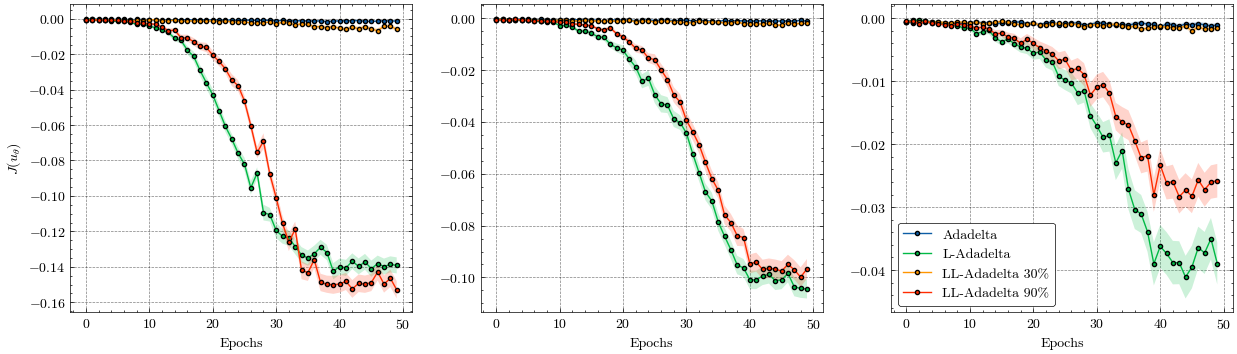

In [16]:
adadelta_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [5e-3, 5e-3, 5e-3],
    [30, 90],
    50,
    40,
    rho=0.95,
)

Oil Drilling: Epoch 49, RMSprop, lr=0.000, sigma=0.000, train=-0.159, test=-0.160: 100%|██████████| 50/50 [00:08<00:00,  6.10it/s]
Oil Drilling: Epoch 49, L-RMSprop, lr=0.000, sigma=0.000, train=-0.189, test=-0.205: 100%|██████████| 50/50 [00:08<00:00,  6.11it/s]
Oil Drilling: Epoch 49, LL-RMSprop 30%, lr=0.000, sigma=0.000, train=-0.160, test=-0.163: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]
Oil Drilling: Epoch 49, LL-RMSprop 90%, lr=0.000, sigma=0.000, train=-0.198, test=-0.202: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]
Oil Drilling: Epoch 49, RMSprop, lr=0.000, sigma=0.000, train=-0.161, test=-0.165: 100%|██████████| 50/50 [00:14<00:00,  3.39it/s]
Oil Drilling: Epoch 49, L-RMSprop, lr=0.000, sigma=0.000, train=-0.204, test=-0.205: 100%|██████████| 50/50 [00:14<00:00,  3.38it/s]
Oil Drilling: Epoch 49, LL-RMSprop 30%, lr=0.000, sigma=0.000, train=-0.178, test=-0.192: 100%|██████████| 50/50 [00:14<00:00,  3.42it/s]
Oil Drilling: Epoch 49, LL-RMSprop 90%, lr=0.000, sigma=0.

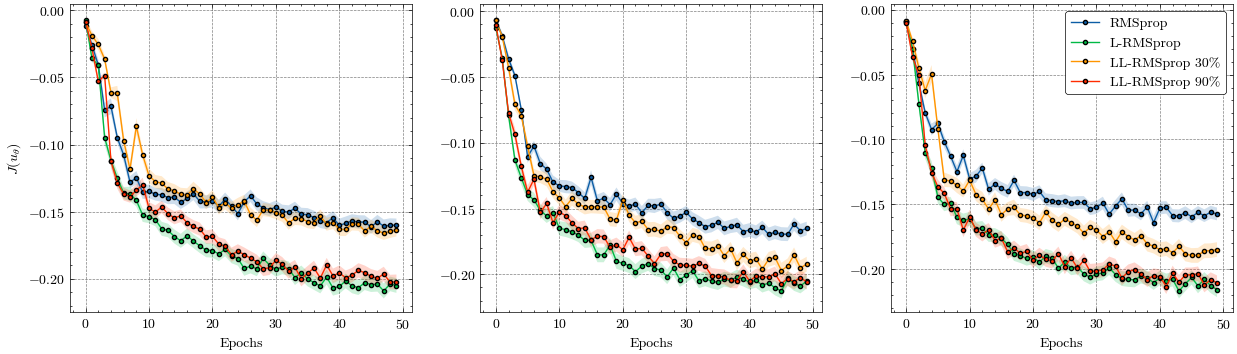

In [17]:
rmsprop_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [2e-3, 2e-3, 2e-3],
    [30, 90],
    50,
    40,
)

Oil Drilling: Epoch 49, SGD, lr=0.005, sigma=0.000, train=-0.003, test=-0.002: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s]
Oil Drilling: Epoch 49, L-SGD, lr=0.005, sigma=0.000, train=-0.005, test=-0.007: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]
Oil Drilling: Epoch 49, LL-SGD 30%, lr=0.005, sigma=0.000, train=-0.002, test=-0.002: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s]
Oil Drilling: Epoch 49, LL-SGD 90%, lr=0.005, sigma=0.000, train=-0.005, test=-0.007: 100%|██████████| 50/50 [00:07<00:00,  6.37it/s]
Oil Drilling: Epoch 49, SGD, lr=0.005, sigma=0.000, train=-0.000, test=-0.002: 100%|██████████| 50/50 [00:14<00:00,  3.44it/s]
Oil Drilling: Epoch 49, L-SGD, lr=0.005, sigma=0.000, train=-0.003, test=-0.004: 100%|██████████| 50/50 [00:15<00:00,  3.32it/s]
Oil Drilling: Epoch 49, LL-SGD 30%, lr=0.005, sigma=0.000, train=-0.001, test=-0.002: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]
Oil Drilling: Epoch 49, LL-SGD 90%, lr=0.005, sigma=0.000, train=-0.002, test=-0.002: 

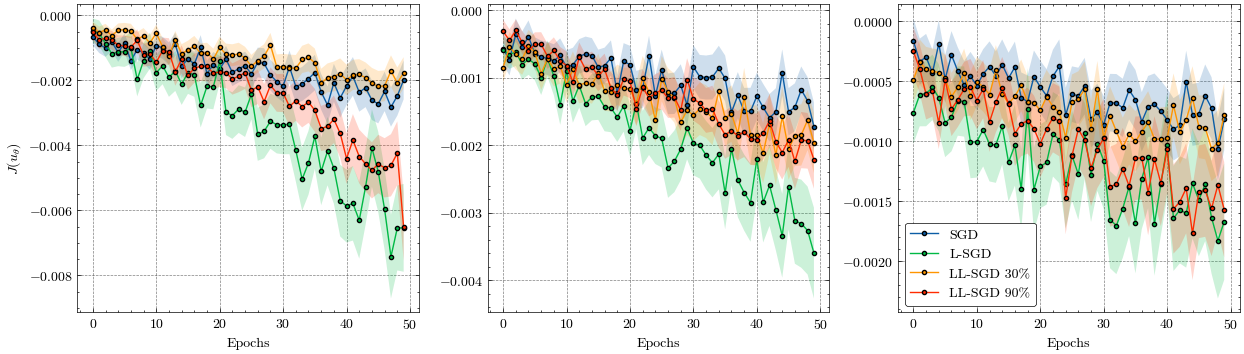

In [18]:
sgd_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.SGD,
    APLSGD,
    "SGD",
    5e-2,
    5e-3,
    [2e-3, 2e-3, 2e-3],
    [30, 90],
    50,
    40,
    momentum=0.9,
)

In [19]:
if os.path.isdir("graphs/oil_drilling"):
    adam_multiple_ctrl.savefig("graphs/oil_drilling/adam_multiple_ctrl.pdf")
    adadelta_multiple_ctrl.savefig("graphs/oil_drilling/adadelta_multiple_ctrl.pdf")
    rmsprop_multiple_ctrl.savefig("graphs/oil_drilling/rmsprop_multiple_ctrl.pdf")
    sgd_multiple_ctrl.savefig("graphs/oil_drilling/sgd_multiple_ctrl.pdf")
    adagrad_multiple_ctrl.savefig("graphs/oil_drilling/adagrad_multiple_ctrl.pdf")

### Sample trajectory:

In [20]:
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim).to(device),
    U=(lambda x: x),
    device=device,
)

control_config = dict(
    input_dim=1 + 3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

In [21]:
epochs = 80
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3, weight_decay=0.01)

scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=60
)

In [22]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=0.000, train=-0.154, test=-0.158: 100%|██████████| 80/80 [00:37<00:00,  2.14it/s]


In [23]:
P, S, E, q = ocp.sample_traj(1)

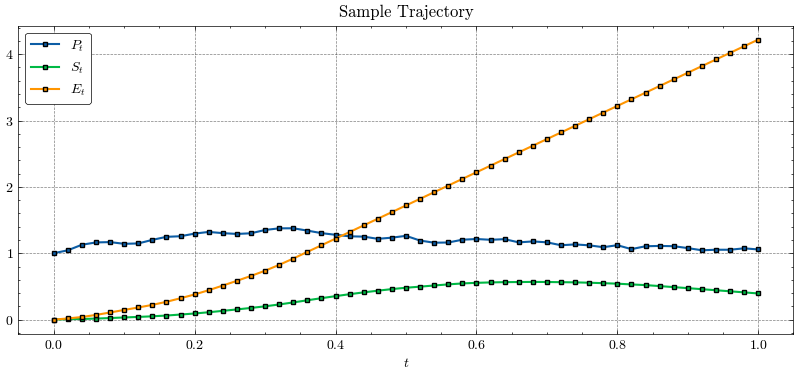

In [24]:
fig = plt.figure(figsize=(10, 4))

t = model_config["T"] / model_config["N_euler"] * np.arange(model_config["N_euler"] + 1)
plt.plot(
    t,
    P.flatten().detach().numpy(),
    label=r"$P_t$",
    marker="s",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t, S.flatten().detach().numpy(), label=r"$S_t$", marker="s", mec="k", ms=3, lw=1.5
)
plt.plot(
    t, E.flatten().detach().numpy(), label=r"$E_t$", marker="s", mec="k", ms=3, lw=1.5
)

legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.title("Sample Trajectory")
plt.xlabel(r"$t$")
# fig.savefig("graphs/oil_drilling/Sample_traj_oil_N50.pdf")
plt.show()
plt.close()